# Imports

In [80]:
import sys
sys.path.append('..')

In [81]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import alignment.alignment_utils as utils

%matplotlib inline

# Load in data

### Real data

In [1]:
DATA_PATH = '../data/'
data_filename = DATA_PATH + 'pt_decoding_data_S22.pkl'
# data_filename = DATA_PATH + 'pt_decoding_data_S22_zscore.pkl'

In [83]:
all_pt_data = utils.load_pkl(data_filename)

In [84]:
pt = 'S14'
pt_data = all_pt_data[pt]
print(pt_data.keys())

dict_keys(['ID', 'X1', 'X1_map', 'y1', 'X2', 'X2_map', 'y2', 'X3', 'X3_map', 'y3', 'y_full_phon', 'X_collapsed', 'y_phon_collapsed', 'y_artic_collapsed', 'pre_pts'])


### Surrogate TME data

In [85]:
# surr_type = 'TC_randomN'
surr_type = 'TNC'
surr_suffix = ''
# surr_suffix = '_zscore'
surr_data = sio.loadmat(f'../data/{pt}/TME/{pt}_TME_{surr_type}{surr_suffix}.mat')['surrTensor']

## Phoneme label processing functions

In [86]:
phon_labels = np.array(['a', 'ae', 'i', 'u', 'b', 'p', 'v', 'g', 'k'])
artic_labels = np.array(['low', 'high', 'labial', 'dorsal'])
phon_to_artic_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4}

In [87]:
def phon_to_artic(phon_idx, phon_to_artic_conv):
    return phon_to_artic_conv[phon_idx]

def phon_to_artic_seq(phon_seq, phon_to_artic_conv):
    flat_seq = phon_seq.flatten()
    artic_conv = np.array([phon_to_artic(phon_idx, phon_to_artic_conv) for phon_idx in flat_seq])
    return np.reshape(artic_conv, phon_seq.shape)

def phon2artic(phon):
    return artic_labels[phon_to_artic_dict[int(phon)] - 1]

def phon2artic_seq(phon_seq):
    return '_'.join([phon2artic(phon) for phon in phon_seq])

def labels2cv_seq(labels):
    labels_str = []
    for lab in labels:
        labels_str.append(labels2cv(lab))
    return np.array(labels_str)

def labels2cv(str):
    middle_val = str[1]
    if int(middle_val) < 5:
        return 'CVC'
    else:
        return 'VCV'

def articic_nums2seq(artic_num_seqs):
    return np.array([artic_labels[artic_num-1] for artic_num in artic_num_seqs])

## Data Processing

In [88]:
p_ind = 1


pt_trace = pt_data[f'X{p_ind}']  ### Real data
surr_trace = np.transpose(surr_data, [2,0,1])  ### Surrogate data

pt_phon_labels = pt_data[f'y{p_ind}']
pt_phon_seqs = pt_data['y_full_phon']
pt_phon_seqs_str = utils.label_seq2str(pt_phon_seqs)
pt_artic_labels = phon_to_artic_seq(pt_phon_labels, phon_to_artic_dict)
pt_artic_seqs = phon_to_artic_seq(pt_phon_seqs, phon_to_artic_dict)
pt_artic_seqs_str = utils.label_seq2str(pt_artic_seqs)
pt_cv_labels = labels2cv_seq(pt_phon_seqs)
pt_phon_seq_names = utils.label_seq2str(np.array([[phon_labels[int(i)-1] for i in x] for x in pt_phon_seqs_str]))

In [89]:
artic_seq_strs = articic_nums2seq(pt_artic_seqs)
artic_seq_strs = np.array([[s[0:2] + '_' for s in labs] for labs in artic_seq_strs])
artic_seq_strs = utils.label2str(artic_seq_strs)
artic_seq_strs = np.array([s[0:-1] for s in artic_seq_strs])

In [90]:
t = np.linspace(-0.5, 0.5 - 1/pt_trace.shape[1], pt_trace.shape[1])

In [91]:
phon_seq_avg_trace = utils.cnd_avg(pt_trace, pt_phon_seqs_str)
artic_seq_avg_trace = utils.cnd_avg(pt_trace, pt_artic_seqs_str)
phon_avg_trace = utils.cnd_avg(pt_trace, pt_phon_labels)
artic_avg_trace = utils.cnd_avg(pt_trace, pt_artic_labels)
cv_avg_trace = utils.cnd_avg(pt_trace, pt_cv_labels)

# Data Visualization

## Plotting Util

In [92]:
def line(error_y_mode=None, **kwargs):
    """Extension of `plotly.express.line` to use error bands.
    
    From https://stackoverflow.com/questions/69587547/continuous-error-band-with-plotly-express-in-python, user171780"""
    ERROR_MODES = {'bar','band','bars','bands',None}
    if error_y_mode not in ERROR_MODES:
        raise ValueError(f"'error_y_mode' must be one of {ERROR_MODES}, received {repr(error_y_mode)}.")
    if error_y_mode in {'bar','bars',None}:
        fig = px.line(**kwargs)
    elif error_y_mode in {'band','bands'}:
        if 'error_y' not in kwargs:
            raise ValueError(f"If you provide argument 'error_y_mode' you must also provide 'error_y'.")
        figure_with_error_bars = px.line(**kwargs)
        fig = px.line(**{arg: val for arg,val in kwargs.items() if arg != 'error_y'})
        for data in figure_with_error_bars.data:
            x = list(data['x'])
            y_upper = list(data['y'] + data['error_y']['array'])
            y_lower = list(data['y'] - data['error_y']['array'] if data['error_y']['arrayminus'] is None else data['y'] - data['error_y']['arrayminus'])
            color = f"rgba({tuple(int(data['line']['color'].lstrip('#')[i:i+2], 16) for i in (0, 2, 4))},.3)".replace('((','(').replace('),',',').replace(' ','')
            fig.add_trace(
                go.Scatter(
                    x = x+x[::-1],
                    y = y_upper+y_lower[::-1],
                    fill = 'toself',
                    fillcolor = color,
                    line = dict(
                        color = 'rgba(255,255,255,0)'
                    ),
                    hoverinfo = "skip",
                    showlegend = False,
                    legendgroup = data['legendgroup'],
                    xaxis = data['xaxis'],
                    yaxis = data['yaxis'],
                )
            )
        # Reorder data as said here: https://stackoverflow.com/a/66854398/8849755
        reordered_data = []
        for i in range(int(len(fig.data)/2)):
            reordered_data.append(fig.data[i+int(len(fig.data)/2)])
            reordered_data.append(fig.data[i])
        fig.data = tuple(reordered_data)
    return fig

## HG Traces

In [93]:
traces = [pt_trace, surr_trace]
trace_labels = ['Real', surr_type + ' Surrogate (TME)']

wide_dfs = []
long_dfs = []
for trace, label in zip(traces, trace_labels):
    d = trace
    n_tr = d.shape[0]
    d = d.reshape(-1, d.shape[-1])
    df_wide = pd.DataFrame(d, columns=[f'Channel {i+1}' for i in range(d.shape[-1])])
    df_wide['Time'] = np.tile(t, n_tr)
    df_wide['Data Type'] = label
    df_wide['Phoneme IDs'] = np.repeat(pt_phon_seqs_str, t.shape[0])
    df_wide['Vowel Sequence'] = df_wide['Phoneme IDs'].apply(labels2cv)
    df_wide['Phoneme Sequence'] = df_wide['Phoneme IDs'].apply(lambda x: ''.join([phon_labels[int(i)-1] for i in x]))
    df_wide['Articulator Sequence'] = df_wide['Phoneme IDs'].apply(phon2artic_seq)
    wide_dfs.append(df_wide)

    df_long = df_wide.melt(id_vars=['Time', 'Data Type', 'Phoneme IDs', 'Vowel Sequence', 'Phoneme Sequence', 'Articulator Sequence'], var_name='Channel', value_name='Value')
    df_long['Channel'] = df_long['Channel'].apply(lambda x: int(x.split(' ')[-1]))
    long_dfs.append(df_long)

trace_df_wide = pd.concat(wide_dfs)
trace_df_long = pd.concat(long_dfs)

In [94]:
trace_df_wide

Channel 1  Channel 2  Channel 3  Channel 4  Channel 5  Channel 6  \
0       0.083129  -0.056719   0.188056   0.033680  -0.000943  -0.050639   
1       0.079448  -0.052021   0.178976   0.034285  -0.003758  -0.021775   
2       0.096210  -0.046573   0.159451   0.031316  -0.008327  -0.000574   
3       0.136544  -0.039717   0.135486   0.026753  -0.015178   0.012534   
4       0.198786  -0.032925   0.119634   0.022062  -0.019780   0.017692   
...          ...        ...        ...        ...        ...        ...   
28795   0.011896  -0.026557   0.349450   0.025939   0.168164  -0.113810   
28796   0.068482   0.041582   0.354262   0.023521   0.152767  -0.124582   
28797   0.140764   0.110974   0.362886   0.016711   0.134385  -0.144794   
28798   0.212625   0.160365   0.364441   0.008440   0.126823  -0.151996   
28799   0.274988   0.182477   0.351955   0.006294   0.131717  -0.137034   

       Channel 7  Channel 8  Channel 9  Channel 10  ...  Channel 108  \
0      -0.023476  -0.044213   0.142723   -0.035633  ...    -0.000336   
1      -0.044315  -0.074816   0.180718   -0.020351  ...     0.019604   
2      -0.065430  -0.079151   0.232345   -0.011615  ...     0.032574   
3      -0.090975  -0.051553   0.293191   -0.010963  ...     0.037918   
4      -0.091071  -0.024864   0.357131   -0.017294  ...     0.036205   
...          ...        ...        ...         ...  ...          ...   
28795  -0.335112   0.594307   0.262195    0.186826  ...     0.042316   
28796  -0.354575   0.528919   0.271669    0.195160  ...    -0.031559   
28797  -0.339036   0.451041   0.289817    0.198887  ...    -0.106289   
28798  -0.289418   0.377850   0.319689    0.197599  ...    -0.173821   
28799  -0.215895   0.316636   0.353531    0.188486  ...    -0.230809   

       Channel 109  Channel 110  Channel 111   Time            Data Type  \
0        -0.137136     0.120209    -0.161540 -0.500                 Real   
1        -0.133855     0.128484    -0.158694 -0.495                 Real   
2        -0.128403     0.126644    -0.164217 -0.490                 Real   
3        -0.116056     0.117056    -0.171346 -0.485                 Real   
4        -0.102067     0.106526    -0.164831 -0.480                 Real   
...            ...          ...          ...    ...                  ...   
28795    -0.247389     0.124345     0.206844  0.475  TNC Surrogate (TME)   
28796    -0.265865     0.072561     0.143062  0.480  TNC Surrogate (TME)   
28797    -0.284366     0.012528     0.088401  0.485  TNC Surrogate (TME)   
28798    -0.310309    -0.043067     0.049457  0.490  TNC Surrogate (TME)   
28799    -0.343542    -0.083608     0.022181  0.495  TNC Surrogate (TME)   

       Phoneme IDs  Vowel Sequence  Phoneme Sequence  Articulator Sequence  
0              915             CVC               kab     dorsal_low_labial  
1              915             CVC               kab     dorsal_low_labial  
2              915             CVC               kab     dorsal_low_labial  
3              915             CVC               kab     dorsal_low_labial  
4              915             CVC               kab     dorsal_low_labial  
...            ...             ...               ...                   ...  
28795          836             CVC               gip    dorsal_high_labial  
28796          836             CVC               gip    dorsal_high_labial  
28797          836             CVC               gip    dorsal_high_labial  
28798          836             CVC               gip    dorsal_high_labial  
28799          836             CVC               gip    dorsal_high_labial  

[57600 rows x 117 columns]

In [95]:
# fig_df = trace_df_long.drop(columns=['Channel', 'Phoneme IDs', 'Phoneme Sequence', 'Articulator Sequence']).groupby(['Time', 'Data Type', 'Vowel Sequence']).mean().reset_index()
# fig_df['std'] = trace_df_long.drop(columns=['Channel', 'Phoneme IDs', 'Phoneme Sequence', 'Articulator Sequence']).groupby(['Time', 'Data Type', 'Vowel Sequence']).std().reset_index()['Value']
# fig_df['count'] = trace_df_long.drop(columns=['Channel', 'Phoneme IDs', 'Phoneme Sequence', 'Articulator Sequence']).groupby(['Time', 'Data Type', 'Vowel Sequence']).count().reset_index()['Value']
# fig_df['CI'] = 1.96 * (fig_df['std'] / np.sqrt(fig_df['count']))
# fig_df['Vowel Sequence'] = fig_df['Vowel Sequence'].apply(lambda x: x.replace('CVC', 'Consonant-Vowel-Consonant').replace('VCV', 'Vowel-Consonant-Vowel'))
# fig = line( data_frame=fig_df, x='Time', y='Value', error_y='CI',
#            error_y_mode='band', color='Vowel Sequence', width=1200, height=500,
#            facet_col='Data Type', facet_col_spacing=0.12)

fig_df = trace_df_long.drop(columns=['Channel', 'Phoneme IDs', 'Vowel Sequence', 'Articulator Sequence']).groupby(['Time', 'Data Type', 'Phoneme Sequence']).mean().reset_index()
fig_df['std'] = trace_df_long.drop(columns=['Channel', 'Phoneme IDs', 'Vowel Sequence', 'Articulator Sequence']).groupby(['Time', 'Data Type', 'Phoneme Sequence']).std().reset_index()['Value']
fig_df['count'] = trace_df_long.drop(columns=['Channel', 'Phoneme IDs', 'Vowel Sequence', 'Articulator Sequence']).groupby(['Time', 'Data Type', 'Phoneme Sequence']).count().reset_index()['Value']
fig_df['CI'] = 1.96 * (fig_df['std'] / np.sqrt(fig_df['count']))
fig = line( data_frame=fig_df, x='Time', y='Value', error_y='CI',
           error_y_mode='band', color='Phoneme Sequence', width=1200, height=650,
           facet_col='Data Type', facet_col_spacing=0.12)

fig.update_traces(line=dict(width=3))
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        title='',
        orientation='h',
        yanchor='bottom',
        # y=-0.35,
        # xanchor='left',
        # x=0.00,
        y=-0.7,
        xanchor='right',
        x=1.0,
        # bgcolor='White',
        # bordercolor='Black',
        # borderwidth=2,
        font=dict(size=18, family='Arial'),
    ),
    # margin=dict(l=35, r=25, t=125, b=0),
    # showlegend=False,
    # title_text='Latent Dynamics by Patient',
    title_text='HG Power (Significant Channels)',
    title_x= 0.05,
    title_y = 0.99,
    font=dict(size=22, family='Arial'),
)
fig.update_xaxes(
    title='Time Relative to Response Onset (s)',
    # title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # matches=None,
    showticklabels=True,
)
fig.update_yaxes(
    title='HG Power',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # matches=None,
    showticklabels=True,
    title_standoff=0,
)
fig.show()

## Covariance Matrices by Variable

In [96]:
data_centered = np.transpose(pt_trace, [1,2,0])
T = data_centered.shape[0]  # time 
N = data_centered.shape[1]  # channels (n for neurons by convention)
C = data_centered.shape[2]  # conditions

# center data across all modes (T,N,C)
meanT = np.sum(data_centered, axis=(1,2)) / (N*C)
data_centered = data_centered - np.transpose(np.tile(meanT, (N, C, 1)), [2,0,1])
meanN = np.sum(data_centered, axis=(0,2)) / (T*C)
data_centered = data_centered - np.transpose(np.tile(meanN, (T, C, 1)), [0,2,1])
meanC = np.sum(data_centered, axis=(0,1)) / (T*N)
data_centered = data_centered - np.tile(meanC, (T, N, 1))

# time covariance
cov_T = np.einsum('anc,bnc->ab', data_centered, data_centered) / (T-1)

# neuron covariance
cov_N = np.einsum('tac,tbc->ab', data_centered, data_centered) / (N-1)

# condition covariance
cov_C = np.einsum('tna,tnb->ab', data_centered, data_centered) / (C-1)

In [97]:
surr_centered = np.transpose(surr_trace, [1,2,0])

# center data across all modes (T,N,C)
meanT_surr = np.sum(surr_centered, axis=(1,2)) / (N*C)
surr_centered = surr_centered - np.transpose(np.tile(meanT_surr, (N, C, 1)), [2,0,1])
meanN_surr = np.sum(surr_centered, axis=(0,2)) / (T*C)
surr_centered = surr_centered - np.transpose(np.tile(meanN_surr, (T, C, 1)), [0,2,1])
meanC_surr = np.sum(surr_centered, axis=(0,1)) / (T*N)
surr_centered = surr_centered - np.tile(meanC_surr, (T, N, 1))

# time covariance
cov_T_surr = np.einsum('anc,bnc->ab', surr_centered, surr_centered) / (T-1)

# neuron covariance
cov_N_surr = np.einsum('tac,tbc->ab', surr_centered, surr_centered) / (N-1)

# condition covariance
cov_C_surr = np.einsum('tna,tnb->ab', surr_centered, surr_centered) / (C-1)

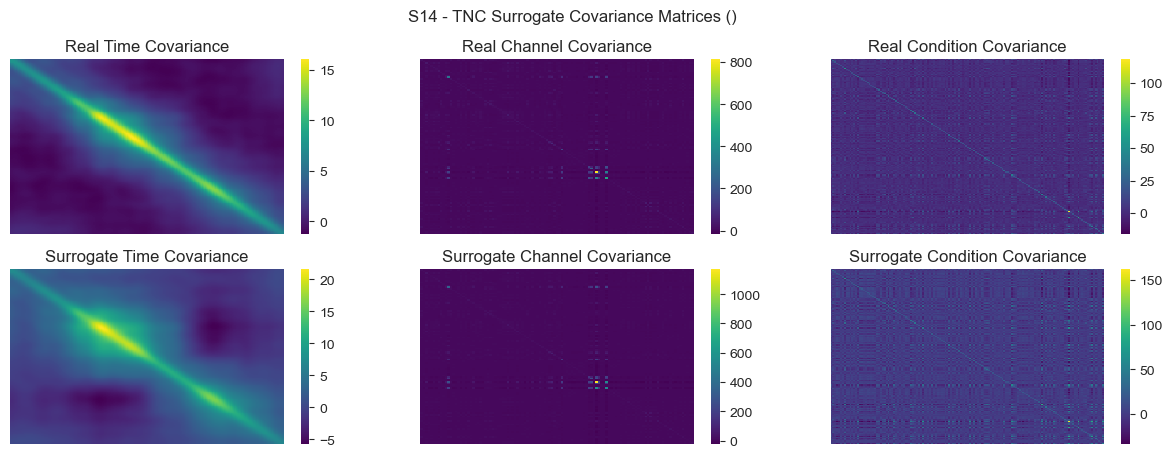

In [98]:
f, axs = plt.subplots(2, 3, figsize=(15,5))

sns.heatmap(cov_T, cmap='viridis', ax=axs[0][0], xticklabels=False, yticklabels=False)
axs[0][0].set_title('Real Time Covariance')
sns.heatmap(cov_N, cmap='viridis', ax=axs[0][1], xticklabels=False, yticklabels=False)
axs[0][1].set_title('Real Channel Covariance')
sns.heatmap(cov_C, cmap='viridis', ax=axs[0][2], xticklabels=False, yticklabels=False)
axs[0][2].set_title('Real Condition Covariance')

sns.heatmap(cov_T_surr, cmap='viridis', ax=axs[1][0], xticklabels=False, yticklabels=False)
axs[1][0].set_title('Surrogate Time Covariance')
sns.heatmap(cov_N_surr, cmap='viridis', ax=axs[1][1], xticklabels=False, yticklabels=False)
axs[1][1].set_title('Surrogate Channel Covariance')
sns.heatmap(cov_C_surr, cmap='viridis', ax=axs[1][2], xticklabels=False, yticklabels=False)
axs[1][2].set_title('Surrogate Condition Covariance')

plt.suptitle(f'{pt} - {surr_type} Surrogate Covariance Matrices ({surr_suffix})')
plt.show()

## jPCA

In [99]:
import jPCA
from jPCA.util import plot_projections

### Plotting Functions

In [100]:
import matplotlib.patheffects as pe
import plotly.express as px

def custom_plot_traj(ax, x, y, 
                    color="black",
                    outline="black",
                    circle=True,
                    arrow=True,
                    circle_size=0.05,
                    arrow_size=0.05):
    """
    Plot a single neural trajectory in a 2D plane.
    
    Args
    ----
        ax: Axis used for plotting.
        
        x: Values of variable on x-axis.
        
        y: Values of variable on y-axis.
        
        color: Fill color of line to be plotted. Defaults to "black".
        
        outline: Outline color of line. Defaults to "black".
        
        circle: True if the trajectory should have a circle at its starting state.
        
        arrow: True if the trajectory should have an arrow at its ending state.
        
    """
    ax.plot(x, y,
             color=color,
             path_effects=[pe.Stroke(linewidth=2, foreground=outline), pe.Normal()])
        
    if circle:
        circ = plt.Circle((x[0], y[0]),
                          radius=circle_size, 
                          facecolor=color,
                          edgecolor="black")
        ax.add_artist(circ)

    if arrow:
        dx = x[-1] - x[-2]
        dy = y[-1] - y[-2]
        px, py = (x[-1], y[-1])
        ax.arrow(px, py , dx, dy, 
                  facecolor=color, 
                  edgecolor=outline,
                  length_includes_head=True,
                #   head_width=arrow_size,
                #   head_length=arrow_size,
                  width=arrow_size,
                  )

def custom_plot_proj(data_list,
                     cnd_labels,
                     x_idx=0,
                     y_idx=1,
                     axis=None,
                     arrows=True,
                     circles=True,
                     arrow_size=0.05,
                     circle_size=0.05):
    """
    Plot trajectories found via jPCA or PCA. 
    
    Args
    ----
        data_list: List of trajectories, where each entry of data_list is an array of size T x D, 
                   where T is the number of time-steps and D is the dimension of the projection.
        cnd_labels: list of labels for each trajectory to allow for color by condition type
        x_idx: column of data which will be plotted on x axis. Default 0.
        y_idx: column of data which will be plotted on y axis. Default 0.
        arrows: True to add arrows to the trajectory plot.
        circles: True to add circles at the beginning of each trajectory.
        sort_colors: True to color trajectories based on the starting x coordinate. This mimics
                     the jPCA matlab toolbox.
    """
    if axis is None:
        fig = plt.figure(figsize=(5,5))
        axis = fig.add_axes([1, 1, 1, 1])

    # colormap = plt.cm.RdBu
    # colors = np.array([colormap(i) for i in np.linspace(0, 1, len(data_list))])
    # colors = px.colors.qualitative.Plotly
    colors = px.colors.qualitative.Plotly * 5
    # colors = px.colors.qualitative.Alphabet
    # colors = px.colors.sequential.Plasma
    data_list = [data[:, [x_idx, y_idx]] for data in data_list]

    legend_lines = []
    for i, data in enumerate(np.array(data_list)):
        custom_plot_traj(axis,
                        data[:, 0],
                        data[:, 1],
                        color=colors[i],
                        circle=circles,
                        arrow=arrows,
                        arrow_size=arrow_size,
                        circle_size=circle_size)
        line, = axis.plot([], [], color=colors[i], label=cnd_labels[i])
        legend_lines.append(line)
    plt.legend(legend_lines, cnd_labels)
    

### jPCA Analysis

In [101]:
jpca = jPCA.JPCA(num_jpcs=6)

In [102]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=10)
# pca_trace = pca.fit_transform(pt_trace.reshape(-1, pt_trace.shape[-1]))
# pca_trace = pca_trace.reshape(pt_trace.shape[0], pt_trace.shape[1], -1)
# print(pca_trace.shape)

In [103]:
# marker_size = 0.14
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# plot_projections([pca_trace[i] for i in range(pca_trace.shape[0]-142)], axis=axes[0], x_idx=0, y_idx=1, arrow_size=marker_size, circle_size=marker_size)
# plot_projections([pca_trace[i] for i in range(pca_trace.shape[0]-142)], axis=axes[1], x_idx=2, y_idx=3, arrow_size=marker_size, circle_size=marker_size)

# axes[0].set_title("PCA Plane 1")
# axes[1].set_title("PCA Plane 2")
# plt.tight_layout()
# plt.show()

In [104]:
t_start = -0.15
t_end = 0.1
t_start_idx = np.where(t >= t_start)[0][0]
t_end_idx = np.where(t <= t_end)[0][-1]
# print(t_start, t_end)
# projected, full_data_var, pca_var_capt, jpca_var_capt = jpca.fit([phon_avg_trace[i] for i in range(phon_avg_trace.shape[0])], times=list(t), tstart=t[t_start_idx], tend=t[t_end_idx], align_axes_to_data=True, num_pcs=30)
# projected, full_data_var, pca_var_capt, jpca_var_capt = jpca.fit([phon_seq_avg_trace[i] for i in range(phon_seq_avg_trace.shape[0])], times=list(t), tstart=t[t_start_idx], tend=t[t_end_idx], align_axes_to_data=True, num_pcs=6)
# projected, full_data_var, pca_var_capt, jpca_var_capt = jpca.fit([artic_seq_avg_trace[i] for i in range(artic_seq_avg_trace.shape[0])], times=list(t), tstart=t[t_start_idx], tend=t[t_end_idx], align_axes_to_data=True, num_pcs=30)
projected, full_data_var, pca_var_capt, jpca_var_capt = jpca.fit([artic_avg_trace[i] for i in range(artic_avg_trace.shape[0])], times=list(t), tstart=t[t_start_idx], tend=t[t_end_idx], align_axes_to_data=True, num_pcs=30)
# projected, full_data_var, pca_var_capt, jpca_var_capt = jpca.fit([cv_avg_trace[i] for i in range(cv_avg_trace.shape[0])], times=list(t), tstart=t[t_start_idx], tend=t[t_end_idx], align_axes_to_data=True, num_pcs=30)
# projected, full_data_var, pca_var_capt, jpca_var_capt = jpca.fit([pt_trace[i] for i in range(pt_trace.shape[0])], times=list(t), tstart=t[t_start_idx], tend=t[t_end_idx], align_axes_to_data=True)
print(f'jPCA projection shape: ({len(projected)}, {projected[0].shape[0]}, {projected[0].shape[1]})')


jPCA projection shape: (4, 51, 6)


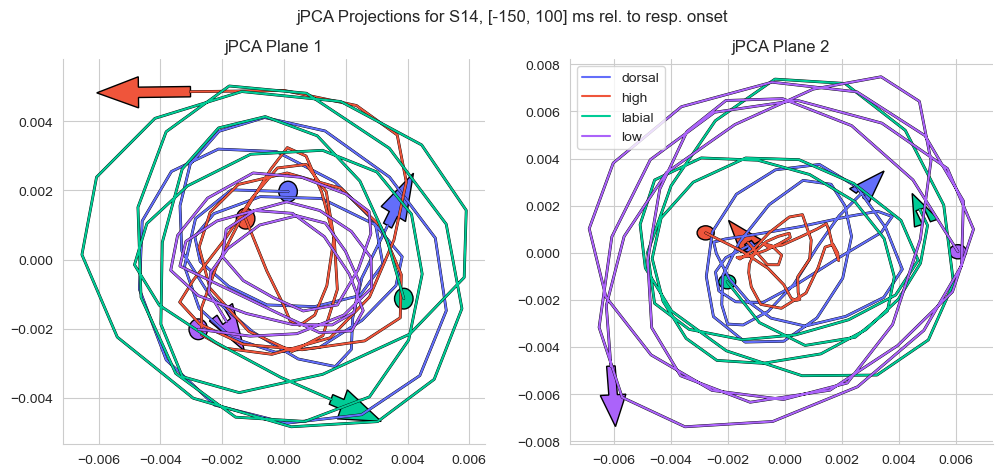

In [105]:
marker_size = 0.0003
# marker_size=0.00003
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# custom_plot_proj(projected, np.unique(pt_cv_labels), axis=axes[0], x_idx=0, y_idx=1, arrow_size=marker_size, circle_size=marker_size)
# custom_plot_proj(projected, np.unique(pt_cv_labels), axis=axes[1], x_idx=2, y_idx=3, arrow_size=marker_size, circle_size=marker_size)
custom_plot_proj(projected, np.unique(artic_labels), axis=axes[0], x_idx=0, y_idx=1, arrow_size=marker_size, circle_size=marker_size)
custom_plot_proj(projected, np.unique(artic_labels), axis=axes[1], x_idx=2, y_idx=3, arrow_size=marker_size, circle_size=marker_size)
# custom_plot_proj(projected, np.unique(artic_seq_strs), axis=axes[0], x_idx=0, y_idx=1, arrow_size=marker_size, circle_size=marker_size)
# custom_plot_proj(projected, np.unique(artic_seq_strs), axis=axes[1], x_idx=2, y_idx=3, arrow_size=marker_size, circle_size=marker_size)
# custom_plot_proj(projected, np.unique(phon_labels), axis=axes[0], x_idx=0, y_idx=1, arrow_size=marker_size, circle_size=marker_size)
# custom_plot_proj(projected, np.unique(phon_labels), axis=axes[1], x_idx=2, y_idx=3, arrow_size=marker_size, circle_size=marker_size)
# custom_plot_proj(projected, np.unique(pt_phon_seq_names), axis=axes[0], x_idx=0, y_idx=1, arrow_size=marker_size, circle_size=marker_size)
# custom_plot_proj(projected, np.unique(pt_phon_seq_names), axis=axes[1], x_idx=2, y_idx=3, arrow_size=marker_size, circle_size=marker_size)

axes[0].set_title("jPCA Plane 1")
axes[1].set_title("jPCA Plane 2")
# plt.tight_layout()
plt.suptitle(f'jPCA Projections for {pt}, [{round(t_start * 1000)}, {round(t_end * 1000)}] ms rel. to resp. onset')
sns.despine()
plt.show()

In [106]:
# Here's how we would get the variance of first plane:
print("Variance captured by each jPC:")
jpca_var_capt / full_data_var

Variance captured by each jPC:


array([1.22904423e-04, 9.06179596e-05, 1.57174797e-04, 1.68412401e-04,
       2.60692117e-04, 2.29394982e-04])

In [107]:
from jPCA.util import preprocess

In [108]:
processed, _, _ = preprocess([pt_trace[i] for i in range(pt_trace.shape[0])], list(t), tstart=t[t_start_idx], tend=t[t_end_idx], num_pcs=30)
proj_seqs, _ = jpca.project(processed)
# proj_seqs, full_data_var, pca_var_capt, jpca_var_capt = jpca.fit([pt_trace[i] for i in range(pt_trace.shape[0])], times=list(t), tstart=t[t_start_idx], tend=t[t_end_idx], align_axes_to_data=True, num_pcs=6)

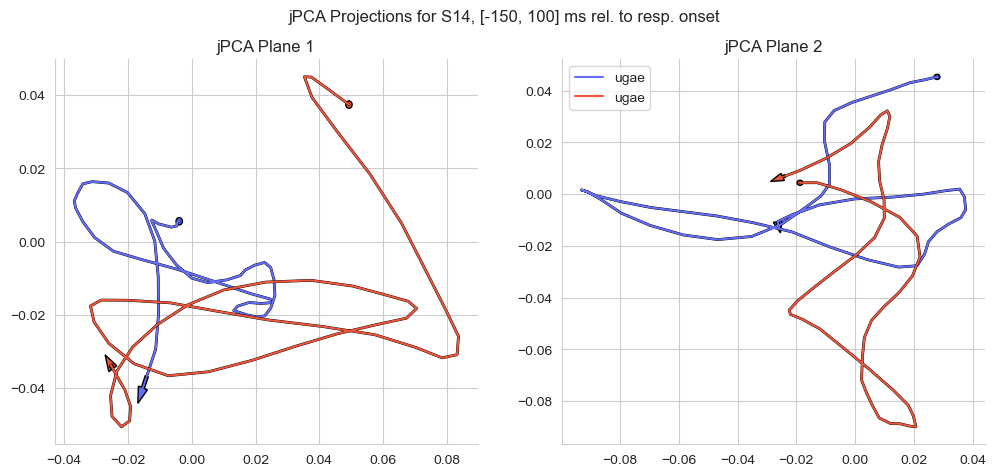

In [109]:
seqs2plot = np.array(['ugae'])
seq_mask = np.isin(pt_phon_seq_names, seqs2plot)

# seqs2plot = np.array(['k'])
# seq_mask = np.isin([phon_labels[p-1] for p in pt_phon_labels], seqs2plot)

projected_masked = [p for i, p in enumerate(proj_seqs) if seq_mask[i]]  # because projected is in list format

marker_size = 0.001
# marker_size=0.00003
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
custom_plot_proj(projected_masked, pt_phon_seq_names[seq_mask], axis=axes[0], x_idx=0, y_idx=1, arrow_size=marker_size, circle_size=marker_size)
custom_plot_proj(projected_masked, pt_phon_seq_names[seq_mask], axis=axes[1], x_idx=2, y_idx=3, arrow_size=marker_size, circle_size=marker_size)
# custom_plot_proj(projected_masked, np.array([phon_labels[p-1] for p in pt_phon_labels])[seq_mask], axis=axes[0], x_idx=0, y_idx=1, arrow_size=marker_size, circle_size=marker_size)
# custom_plot_proj(projected_masked, np.array([phon_labels[p-1] for p in pt_phon_labels])[seq_mask], axis=axes[1], x_idx=2, y_idx=3, arrow_size=marker_size, circle_size=marker_size)

axes[0].set_title("jPCA Plane 1")
axes[1].set_title("jPCA Plane 2")
# plt.tight_layout()
plt.suptitle(f'jPCA Projections for {pt}, [{round(t_start * 1000)}, {round(t_end * 1000)}] ms rel. to resp. onset')
sns.despine()
plt.show()

## dPCA

### Decomposition

In [110]:
from dPCA import dPCA

In [111]:
dpca = dPCA.dPCA(labels='st', regularizer='auto')
dpca.protect = ['t']

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.


In [112]:
dpca_labels = pt_phon_labels
dpca_label_names = phon_labels
pt_labels, trial_counts = np.unique(pt_phon_labels, return_counts=True) 

# dpca_labels = pt_artic_labels
# dpca_label_names = artic_labels
# pt_labels, trial_counts = np.unique(pt_artic_labels, return_counts=True) 

n_stim = len(pt_labels)
n_chans = pt_trace.shape[-1]
n_time = pt_trace.shape[1]
n_samples = np.max(trial_counts)

dpca_trialX = np.nan * np.ones((n_samples, n_chans, n_stim, n_time))
for i, lab in enumerate(pt_labels):
    lab_idx = np.where(dpca_labels == lab)[0]
    lab_trials = pt_trace[lab_idx].swapaxes(-2, -1)
    # print(lab_trials.shape, dpca_trialX[:len(lab_trials), :, i, :].shape)
    dpca_trialX[:len(lab_trials), :, i, :] = lab_trials
print(f'Trial-by-trial data shape: {dpca_trialX.shape}')

Trial-by-trial data shape: (24, 111, 9, 200)


In [113]:
from sklearn.impute import SimpleImputer

imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
dpca_trialX = imp_med.fit_transform(dpca_trialX.reshape(n_samples, -1)).reshape(dpca_trialX.shape)

In [114]:
# trial-average data
dpca_X = np.mean(dpca_trialX, 0)

# center data
dpca_X -= np.mean(dpca_X.reshape((n_chans,-1)),1)[:,None,None]

print(f'Trial-average data shape: {dpca_X.shape}')

Trial-average data shape: (111, 9, 200)


In [115]:
dpca_Z = dpca.fit_transform(dpca_X, dpca_trialX)

Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.003388200529767837
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


In [116]:
dpca_Z.keys()

dict_keys(['s', 't', 'st'])

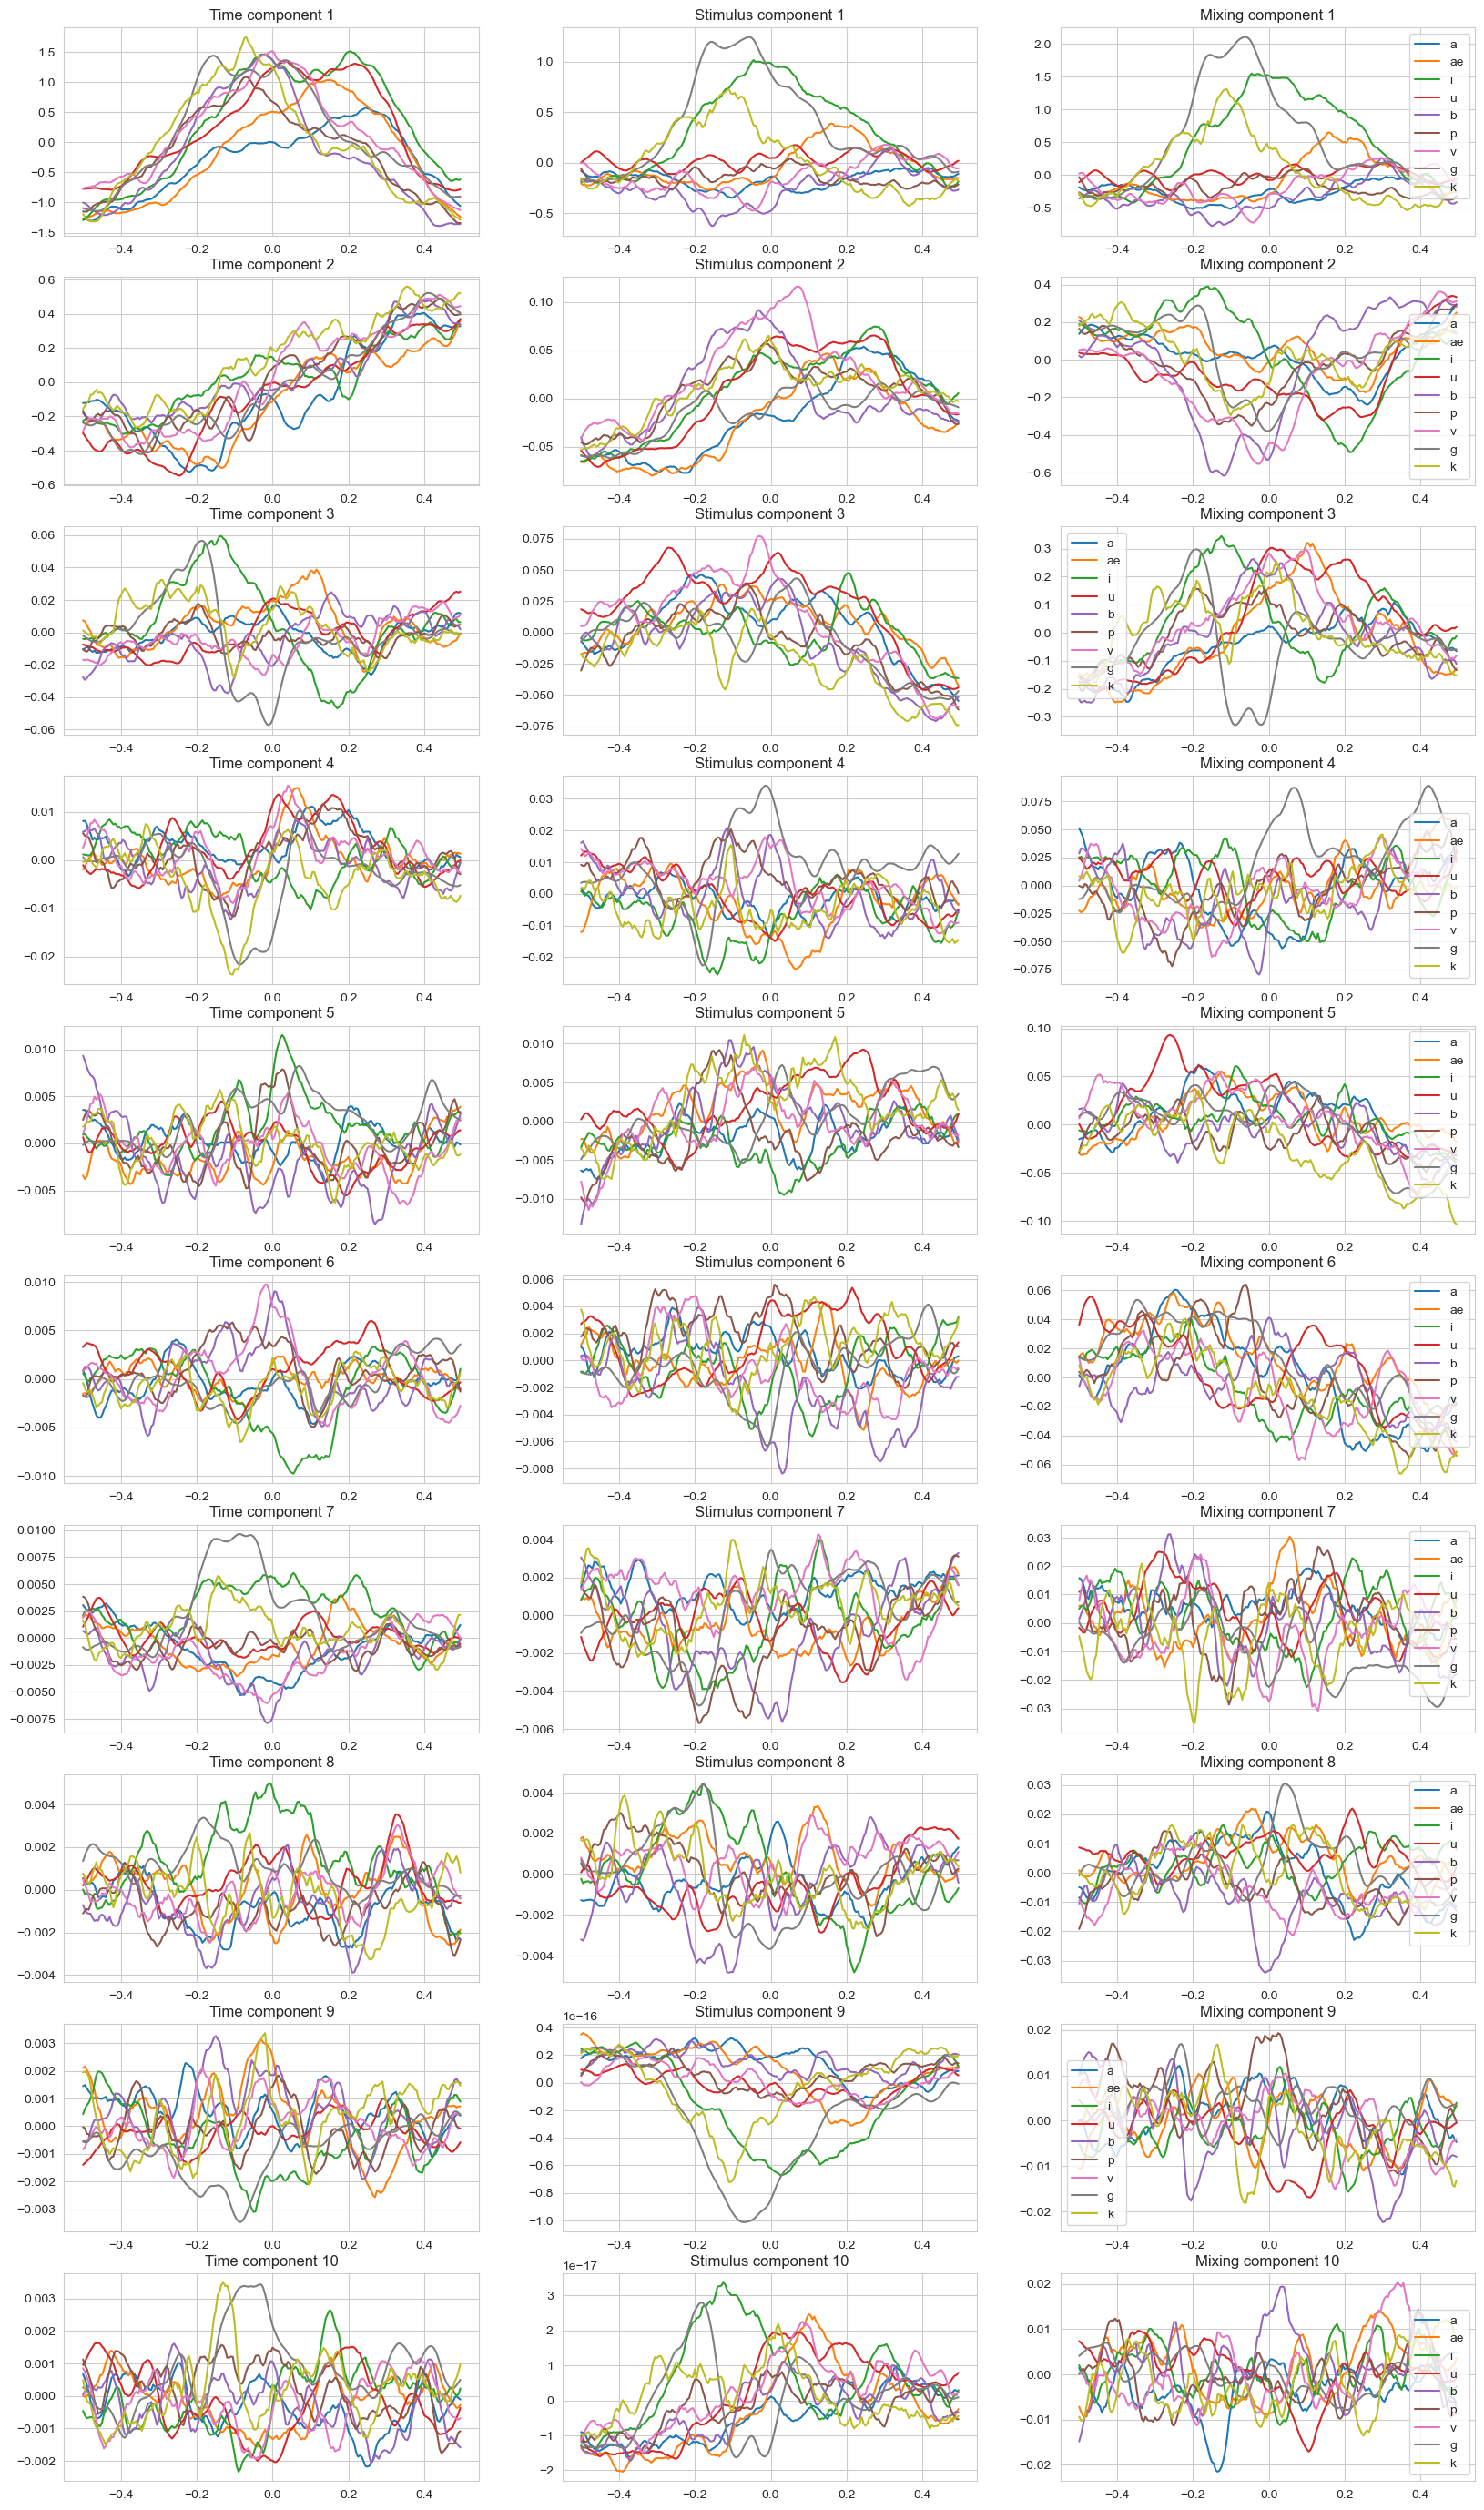

In [117]:
f, axs = plt.subplots(dpca_Z['t'].shape[0], 3, figsize=(20, 35))

for i, ax in enumerate(axs):
    for s in range(n_stim):
        ax[0].plot(t,dpca_Z['t'][i,s], label=dpca_label_names[pt_labels[s]-1])

    ax[0].set_title(f'Time component {i+1}')

    for s in range(n_stim):
        ax[1].plot(t,dpca_Z['s'][i,s], label=dpca_label_names[pt_labels[s]-1])
        
    ax[1].set_title(f'Stimulus component {i+1}')

    for s in range(n_stim):
        ax[2].plot(t,dpca_Z['st'][i,s], label=dpca_label_names[pt_labels[s]-1])
        
    ax[2].set_title(f'Mixing component {i+1}')
    ax[2].legend()
plt.show()

### jPCA - CIS Visualization

In [118]:
cis = np.transpose(dpca_Z['t'][0:1,:,t_start_idx:t_end_idx+1], axes=[1,2,0])
cis.shape

(9, 51, 1)

In [119]:
jpca_plane_1 = np.stack([x[:, 0:2] for x in projected])
jpca_plane_1.shape

(4, 51, 2)

In [120]:
cis_jpca = np.concatenate([cis, jpca_plane_1], axis=2)
cis_jpca.shape

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 9 and the array at index 1 has size 4

In [ ]:
# convert to pandas dataframe
df = pd.DataFrame(cis_jpca.reshape(-1, cis_jpca.shape[-1]))
df.columns = ['CIS', 'jPC1', 'jPC2']
df['time'] = np.tile(t[t_start_idx:t_end_idx+1], cis_jpca.shape[0])
df['condition'] = np.repeat(dpca_label_names[pt_labels-1], cis.shape[1])
df = df.sort_values(by='time')

df

In [ ]:
start = 0
obs = len(df)

# new datastructure for animation
df_ani = pd.DataFrame() # container for df with new datastructure
for i in np.arange(start, obs, cis_jpca.shape[0]):
    curr_df = df.head(i).copy()
    curr_df['Time rel. to Response Onset (s)']= ((i/cis_jpca.shape[0]) - 100) / len(t)
    df_ani = pd.concat([df_ani, curr_df])

In [ ]:
df_ani

In [ ]:
fig = px.line_3d(df_ani, x='jPC1', y='jPC2', z='CIS', color='condition', animation_frame='Time rel. to Response Onset (s)', width=1000, height=600, range_x=[-0.06, 0.06], range_y=[-0.06, 0.06], range_z=[-1.5, 1.6], title=f'jPCA Plane 1 and CIS for {pt}')
# fig = px.line_3d(df_ani, x='jPC1', y='jPC2', z='CIS', animation_frame='time', width=1000, height=600, range_x=[-0.05, 0.05], range_y=[-0.05, 0.05], range_z=[-1.5, 1.6], title=f'jPCA Plane 1 and CIS for {pt}, [{round(t_start * 1000)}, {round(t_end * 1000)}] ms rel. to resp. onset')
fig.update_traces(line=dict(width=4))
# fig2  = px.scatter_3d(df_ani[df_ani['Time rel. to Response Onset (s)'] ==], x='jPC1', y='jPC2', z='CIS', color='condition')
fig.layout.updatemenus[0].buttons[0]['args'][1]['frame']['redraw'] = True
fig.show()

## TSNE Scatters

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
t = np.linspace(-0.5, 0.5 - 1/pt_trace.shape[1], pt_trace.shape[1])
zero_ind = np.where(t == 0)[0][0]

perp = 30
tsne_comp = 2

# pt_embed_t0 = TSNE(n_components=tsne_comp, perplexity=perp).fit_transform(pt_trace[:,zero_ind,:])

t_pca_comp = 0.8
pt_time_pca = PCA(n_components=t_pca_comp).fit_transform(pt_trace.reshape(pt_trace.shape[0], -1))
pt_embed_time = TSNE(n_components=tsne_comp, perplexity=perp).fit_transform(pt_time_pca)


In [ ]:
fig_data = pt_embed_time
fig_labels = pt_artic_labels
fig_label_names = artic_labels

plt.figure()
for lab in np.unique(fig_labels):
    plt.scatter(fig_data[np.where(fig_labels == lab)[0],0], fig_data[np.where(fig_labels == lab)[0],1], label=fig_label_names[lab-1])
# plt.scatter(S14_embed_t0[:,0], S14_embed_t0[:,1], c=S14_artic_labels[:,0])
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title(f'{pt} tSNE Embedding - Phoneme Index {p_ind}')
plt.legend()

sns.despine()
plt.show()